## Preprocessing and Transforming Data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.io.formats import style
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score
from matplotlib_inline.backend_inline import set_matplotlib_formats
import pickle
import warnings


warnings.filterwarnings('ignore')
sns.set_context('notebook', rc={
    'figure.dpi': 100,
    'savefig.dpi': 300
})
sns.set_style('ticks')
set_matplotlib_formats('retina')

In [ ]:
# Load dataset
def load_dataset(path: str) -> pd.DataFrame:
    return pd.read_csv(path, engine='pyarrow', dtype_backend='pyarrow')


PATH = os.path.join(os.getcwd(), 'churn_rate_prediction.csv')
data = load_dataset(PATH)

In [2]:
# Transforming data
def transforming(df: pd.DataFrame) -> pd.DataFrame:
    # Remove "Error" in avg_frequency_login_days
    df = df[df['avg_frequency_login_days'].values != 'Error']

    # Change avg_frequency_login_days to double
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('double[pyarrow]')

    # Change M to Male and F to Female
    df['gender'] = df['gender'].map({
        'M': 'Male',
        'F': 'Female'
    })

    # Change strange values to NaN
    df['gender'] = df['gender'].transform(
        lambda r: None if r == 'Unknown' else r
    )
    df['region_category'] = df['region_category'].transform(
        lambda r: None if r == '' else r
    )
    df['joined_through_referral'] = df['joined_through_referral'].transform(
        lambda r: None if r == '?' else r
    )
    df['preferred_offer_types'] = df['preferred_offer_types'].transform(
        lambda r: None if r == '' else r
    )
    df['medium_of_operation'] = df['medium_of_operation'].transform(
        lambda r: None if r == '?' else r
    )
    df['days_since_last_login'] = df['days_since_last_login'].transform(
        lambda r: None if r < 0 else r
    )
    df['avg_time_spent'] = df['avg_time_spent'].transform(
        lambda r: None if r < 0 else r
    )
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].transform(
        lambda r: None if r < 0 else r
    )
    df['churn_risk_score'] = df['churn_risk_score'].transform(
        lambda r: None if r < 0 else r
    )

    # Change data types
    df = df.astype({
        'age': 'uint8[pyarrow]',
        'gender': 'category',
        'region_category': 'category',
        'membership_category': 'category',
        'joined_through_referral': 'category',
        'preferred_offer_types': 'category',
        'medium_of_operation': 'category',
        'internet_option': 'category',
        'days_since_last_login': 'uint8[pyarrow]',
        'avg_time_spent': 'double[pyarrow]',
        'avg_transaction_value': 'double[pyarrow]',
        'avg_frequency_login_days': 'double[pyarrow]',
        'points_in_wallet': 'double[pyarrow]',
        'used_special_discount': 'category',
        'offer_application_preference': 'category',
        'past_complaint': 'category',
        'complaint_status': 'category',
        'feedback': 'category',
        'churn_risk_score': 'uint8[pyarrow]'
    })

    return df


data = transforming(data.copy())

NameError: name 'data' is not defined

In [90]:
# Preprocessing data
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # Drop unnecessary columns
    df = df.drop(columns=['customer_id', 'Name', 'security_no', 'referral_id'])

    # # Less missing values and dropping
    # threshold = 0.05 * len(df)
    # cols_to_drop = df.columns[df.isna().sum() <= threshold]
    # df.dropna(subset=cols_to_drop, inplace=True)
    #
    # # Imputing missing values of categorical columns with mode
    # categorical_cols = df.select_dtypes(include='category').columns
    # cols_to_impute = categorical_cols[df[categorical_cols].isna().sum() > 0]
    # for col in cols_to_impute:
    #     df[col].fillna(df[col].mode()[0], inplace=True)
    #
    # # Imputing missing values of numerical columns with median
    # numerical_cols = df.select_dtypes(include='number').columns
    # cols_to_impute = numerical_cols[df[numerical_cols].isna().sum() > 0]
    # for col in cols_to_impute:
    #     df[col].fillna(df[col].median(), inplace=True)

    # Drop missing values
    df.dropna(inplace=True)

    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    return df.reset_index(drop=True)


data = preprocessing(data)

## Data and Methods

**Information about the dataset:**
- "age" - The age of the customer
- "gender" - The gender of the customer (Male, Female)
- "region_category" - The region that the customer belongs to (Village, City, Town)
- "membership_category" - The category of the membership that the customer is using (Platinum Membership, Premium Membership, No Membership, Gold Membership, Silver Membership, Basic Membership)
- "joined_through_referral" - Is the customer joined using any referral code (Yes, No)
- "preferred_offer_types" - The Offer that the customer has preferred (Gift Vouchers/Coupons, Credit/Debit Card Offers, Without Offers)
- "medium_of_operation" - The medium of operation that the customer uses (Desktop, Smartphone, Both)
- "internet_option" - The internet options of the customer (Wi-Fi, Mobile_Data, Fiber_Optic)
- "days_since_last_login" - The no. of days passed since the customer last login
- "avg_time_spent" - The average time spent by the customer on the website
- "avg_transaction_value" - The average transaction value of the customer
- "avg_frequency_login_days" - The no. of times the customer has logged in to the website
- "points_in_wallet" - The points awarded to the customer on each transaction
- "used_special_discount" - Indicates whether the customer uses the special discounts offered (Yes, No)
- "offer_application_preference" - Indicates whether the customer prefers offers (Yes, No)
- "past_complaint" - Indicates whether the customer has raised any complaints (Yes, No)
- "complaint_status" - The status of any past complaints (Not Applicable, Solved, Solve in Follow-up, Unsolved, No Information Available)
- "feedback" - The feedback provided by the customer (Products always in Stock, Quality Customer Care, Poor Website, No reason specified, Poor Product Quality, Poor Customer Service, Too many ads, User Friendly Website, Reasonable Price)
- "churn_risk_score" - The churn risk score of the customer (1 - 5)

**Remarks on the dataset:**
- The dataset has 15985 rows and 21 columns, with no missing values or duplicate rows. All numeric columns are positive numbers. To prevent data leakage, we imputed missing values of categorical columns with mode and numerical columns with median, and retained the outliers.

**Methods:**
Our exploratory data analysis involved various methodologies, including data cleaning, data visualization, statistical analysis, and machine learning algorithms. To clean the data, we used Pandas to handle missing values, and outliers, and transform variables as necessary. We also used Scikit-learn tools, such as One-Hot-Encoder, to prepare the data for machine learning algorithms. For visualization, we employed Matplotlib and Seaborn to create various plots, including barplots, lineplots, and heat maps, to identify patterns and relationships. Additionally, we utilized the Scipy library for statistical analysis, including the Chi-square test to understand relationships between variables. For machine learning, we implemented various algorithms, such as k-Nearest Neighbors, Logistic Regression, and Random Forests, and evaluated the models based on accuracy, precision, recall, F1 score, and cross-validation. We also used the Scikit-optimize library to optimize the hyperparameters of the models.

In [91]:
data.head()

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,44,Female,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
1,37,Male,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
2,31,Female,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5
3,21,Male,Town,Gold Membership,2015-03-19,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11:40:04,...,55.38,8982.50,28.0,756.21,Yes,No,Yes,Solved in Follow-up,No reason specified,3
4,25,Female,Village,Basic Membership,2016-05-22,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,05:57:20,...,570.23,35119.93,8.0,699.70,Yes,Yes,No,Not Applicable,Poor Product Quality,5


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15985 entries, 0 to 15984
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype               
---  ------                        --------------  -----               
 0   age                           15985 non-null  uint8[pyarrow]      
 1   gender                        15985 non-null  category            
 2   region_category               15985 non-null  category            
 3   membership_category           15985 non-null  category            
 4   joining_date                  15985 non-null  date32[day][pyarrow]
 5   joined_through_referral       15985 non-null  category            
 6   preferred_offer_types         15985 non-null  category            
 7   medium_of_operation           15985 non-null  category            
 8   internet_option               15985 non-null  category            
 9   last_visit_time               15985 non-null  time32[s][pyarrow]  
 10  days_since_last_login 

## Exploratory Data Analysis

In [93]:
# Divide age into 4 groups
def divide_age_group(df: pd.DataFrame) -> pd.DataFrame:
    age_group = [int(df.age.quantile(i / 4)) for i in range(5)]
    age_group[0] -= 1
    labels = []
    for i in range(len(age_group) - 1):
        labels.append(f'{age_group[i] + 1} - {age_group[i + 1]}')
    df['age_group'] = pd.cut(df['age'], bins=age_group, labels=labels)

    return df


eda = divide_age_group(data.copy())

In [94]:
eda['churn_risk_score'] = eda['churn_risk_score'].astype('category')

num = eda.select_dtypes(include='number')
cat = eda.select_dtypes(include='category')
dt = eda.select_dtypes(exclude=['number', 'category'])

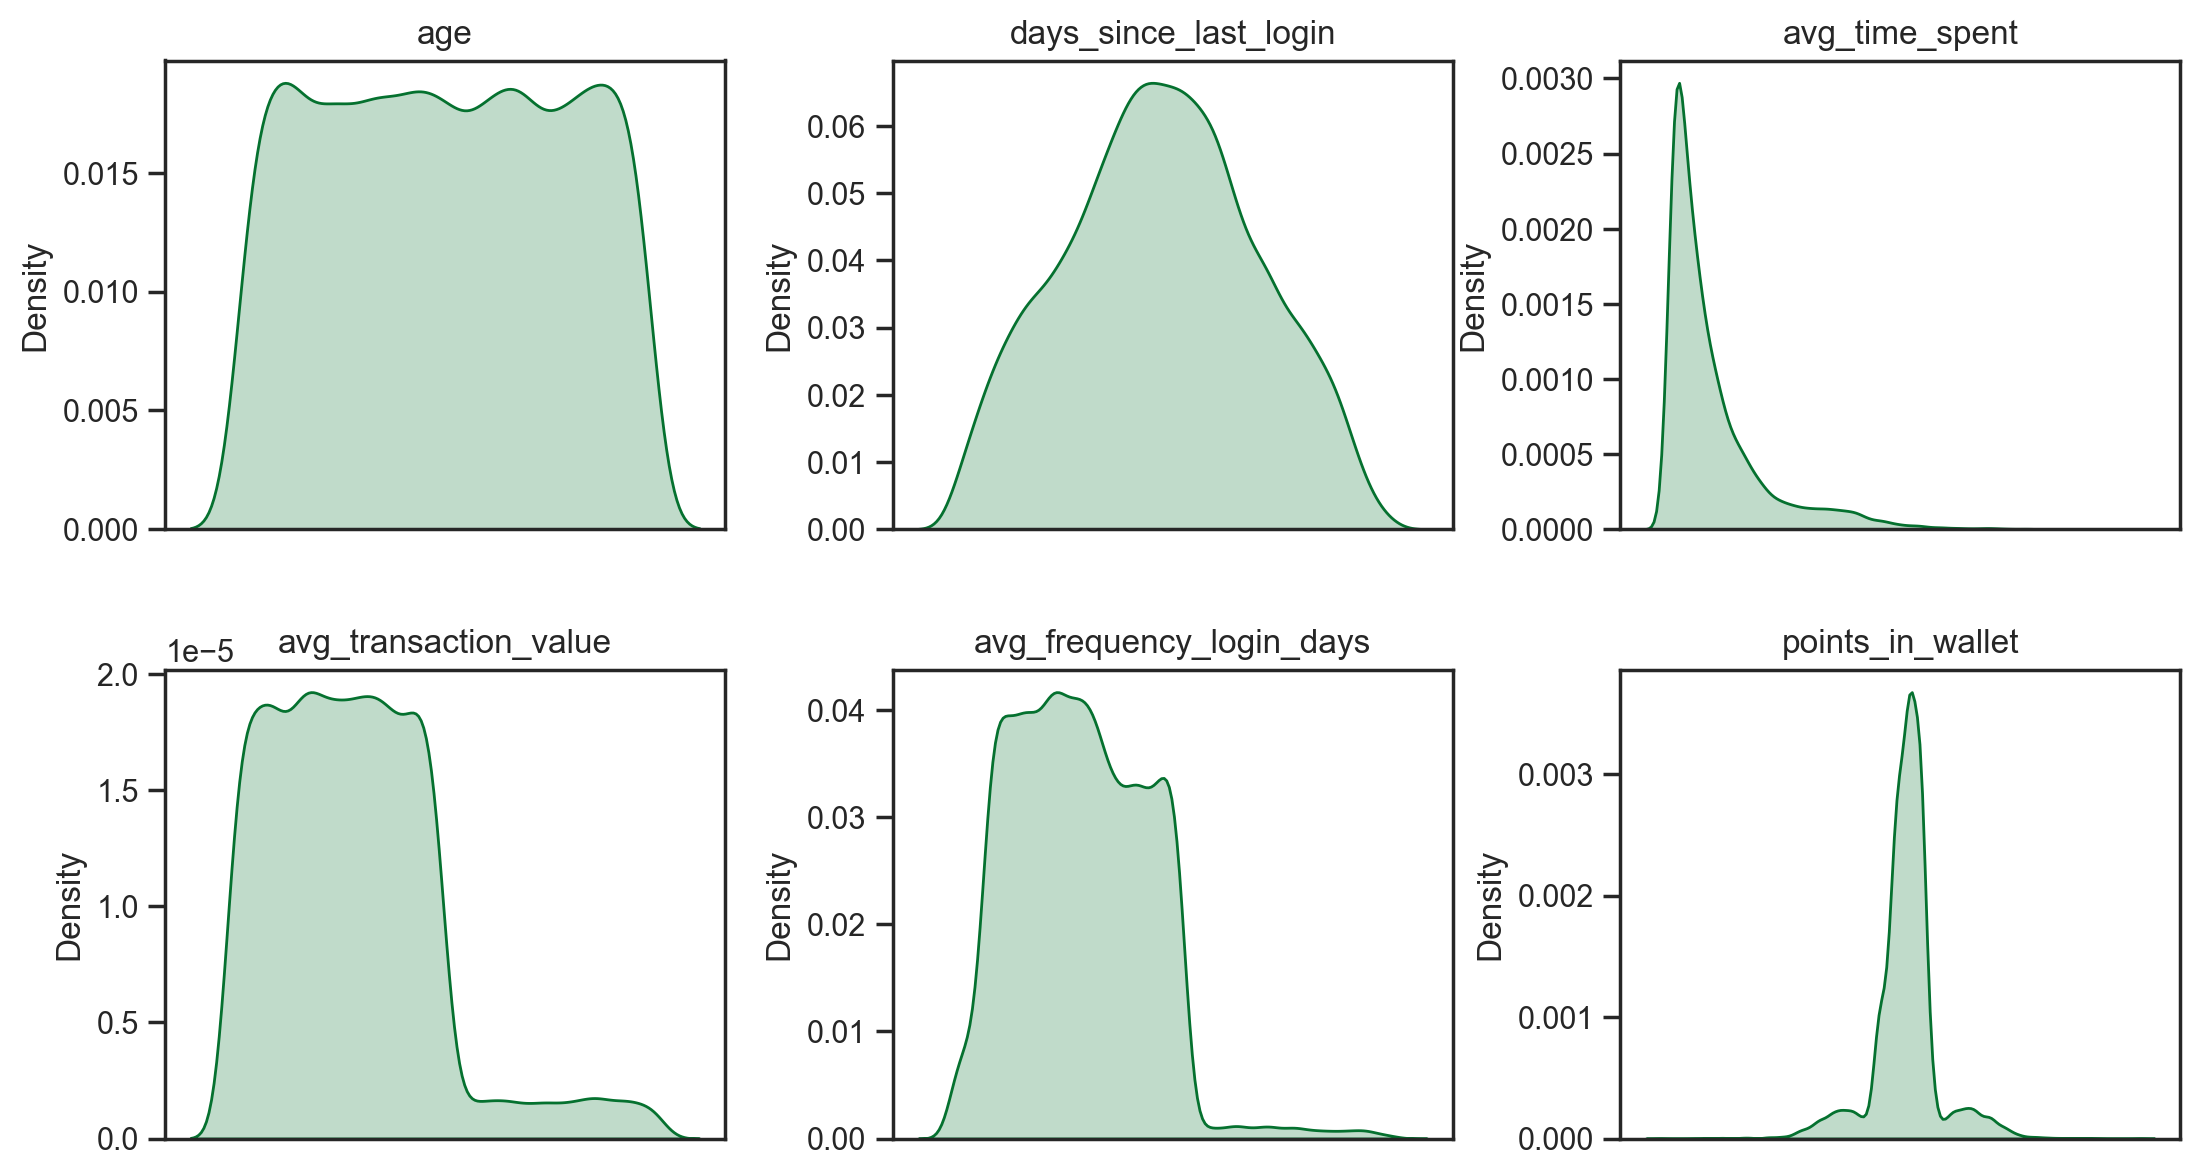

In [95]:
# Plotting the distribution of numerical variables
def plot_distribution(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_distribution(num)

In [96]:
# Formatting table
def format_table(df: pd.DataFrame) -> style.Styler:
    return (
        df.style
        .set_properties(
            **{
                'font-size': '10pt',
                'width': '100px',
                'height': '30px',
                'text-align': 'center'
            }
        )
        .set_table_styles([
            {
                'selector': 'th',
                'props': [
                    ('text-align', 'center'),
                    ('font-size', '10pt')
                ]
            },
            {
                'selector': 'caption',
                'props': [
                    ('caption-side', 'bottom'),
                    ('text-align', 'center'),
                    ('font-size', '12pt'),
                    ('padding-top', '10pt')
                ]
            }
        ])
        .set_table_attributes(
            'style="font-size: 16px; margin: 0 auto;"'
        )
    )

In [97]:
# Table of basic statistics
def basic_statistics(df: pd.DataFrame) -> style.Styler:
    return (
        format_table(df.describe())
        .background_gradient(cmap='Paired')
        .set_caption('Table 1. Basic Statistics of the Data')
    )


basic_statistics(num)

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
count,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000,15985.000000
mean,36.939756,12.803628,292.740651,29310.203352,16.562433,688.448887
std,15.901428,5.597767,335.032313,19535.947299,8.386464,193.600131
min,10.000000,1.000000,1.837399,800.460000,0.009208,-760.661236
25%,23.000000,9.000000,70.850000,14301.920000,10.000000,617.760000
50%,37.000000,13.000000,173.180000,27395.550000,16.000000,699.350000
75%,51.000000,17.000000,369.880000,40740.980000,23.000000,765.070000
max,64.000000,26.000000,3040.410000,99914.050000,56.161979,2069.069761


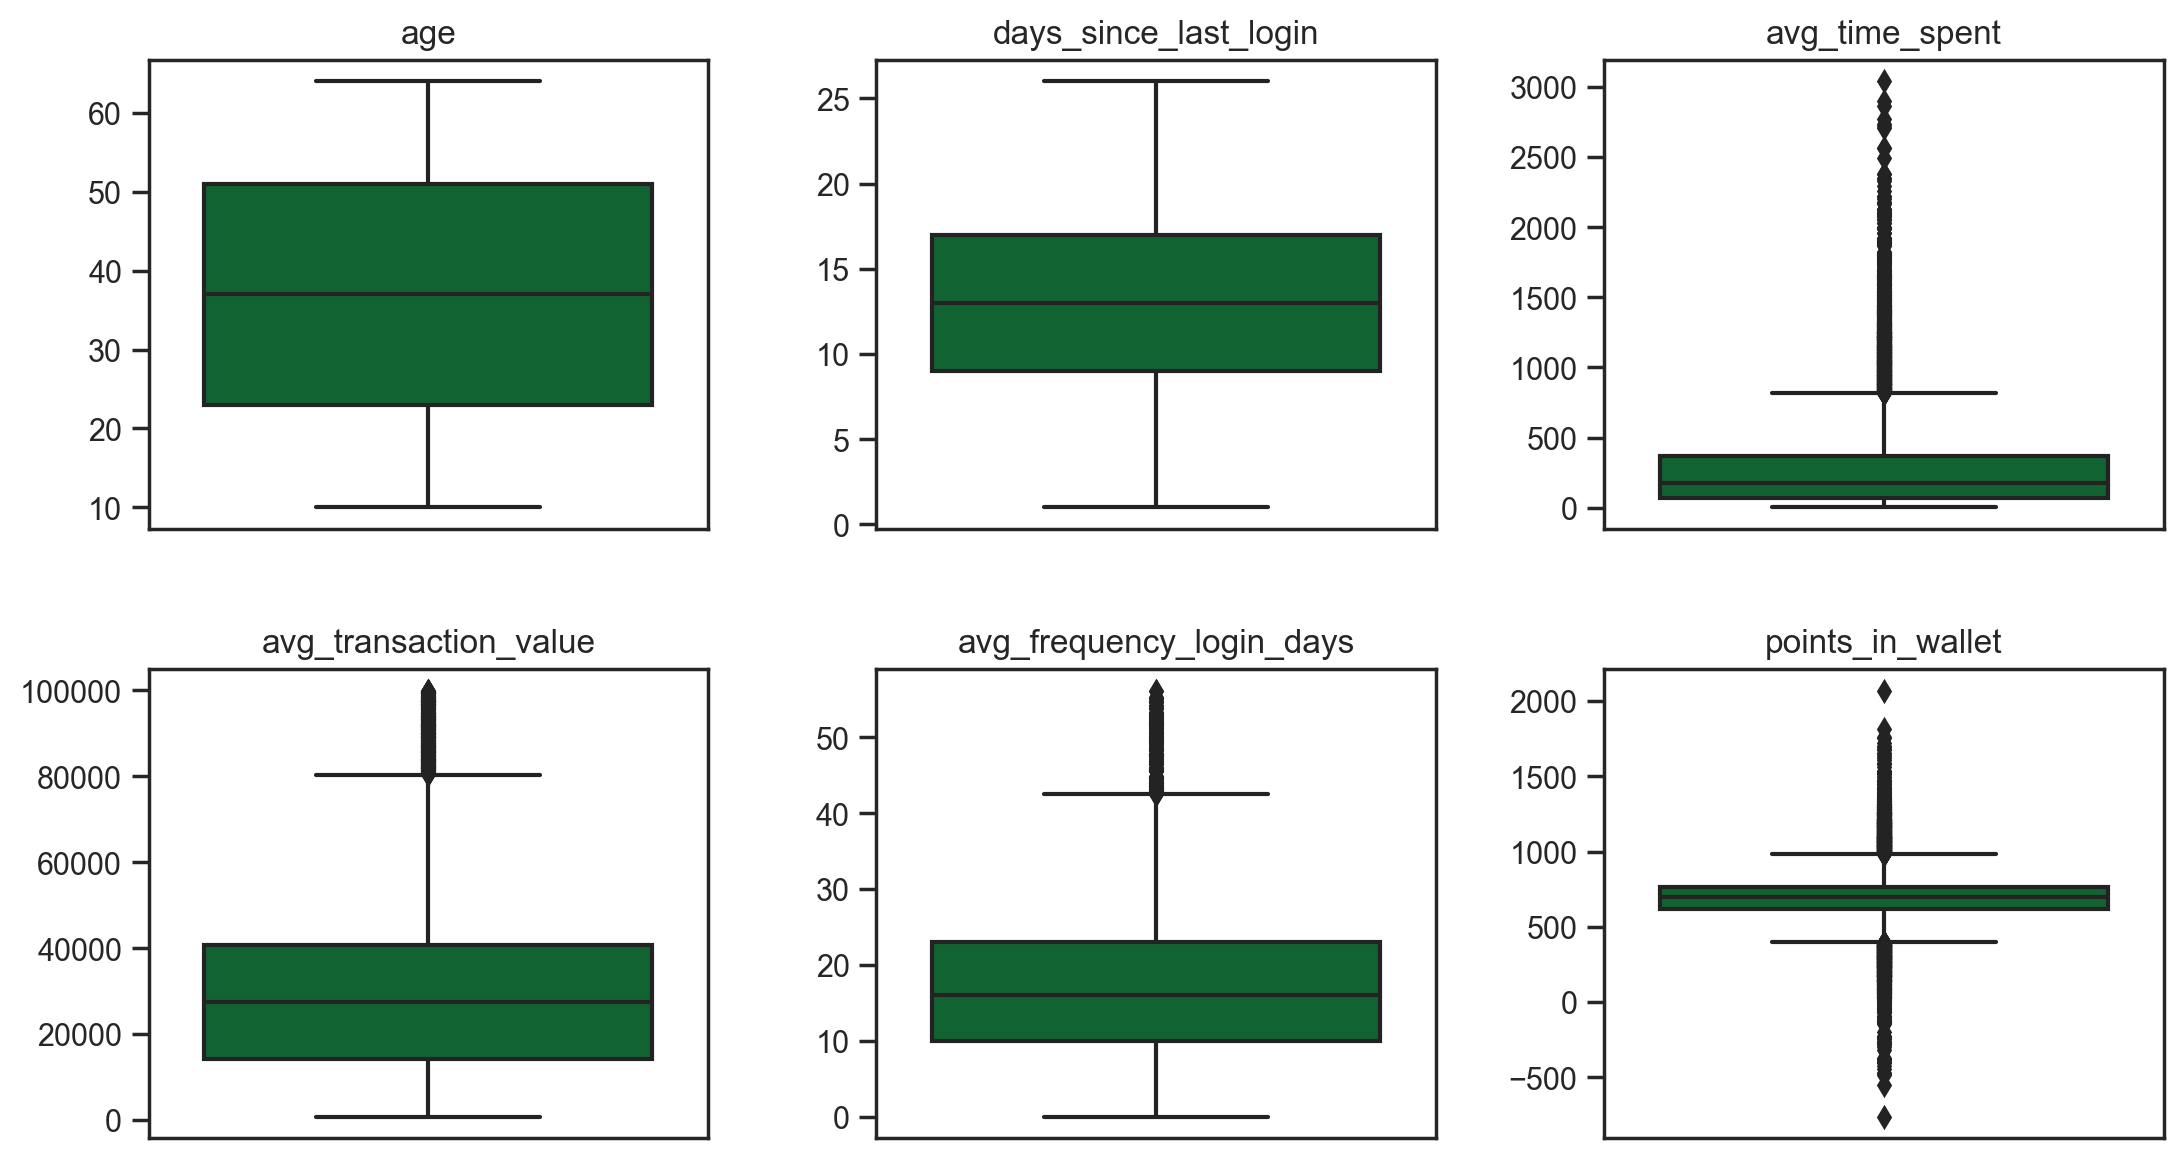

In [98]:
# Plotting the statistics of the numerical features
def plot_statistics(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.boxplot(df[col], ax=ax)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_statistics(num)

In [99]:
# Table of the number of outliers
def outliers(df: pd.DataFrame) -> style.Styler:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return (
        format_table(
            ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr)))
            .sum()
            .to_frame('number_of_outliers')
        )
        .background_gradient(cmap='Paired')
        .set_caption('Table 2. Number of outliers')
    )


outliers(num)

,number_of_outliers
age,0
days_since_last_login,0
avg_time_spent,1344
avg_transaction_value,506
avg_frequency_login_days,158
points_in_wallet,2058


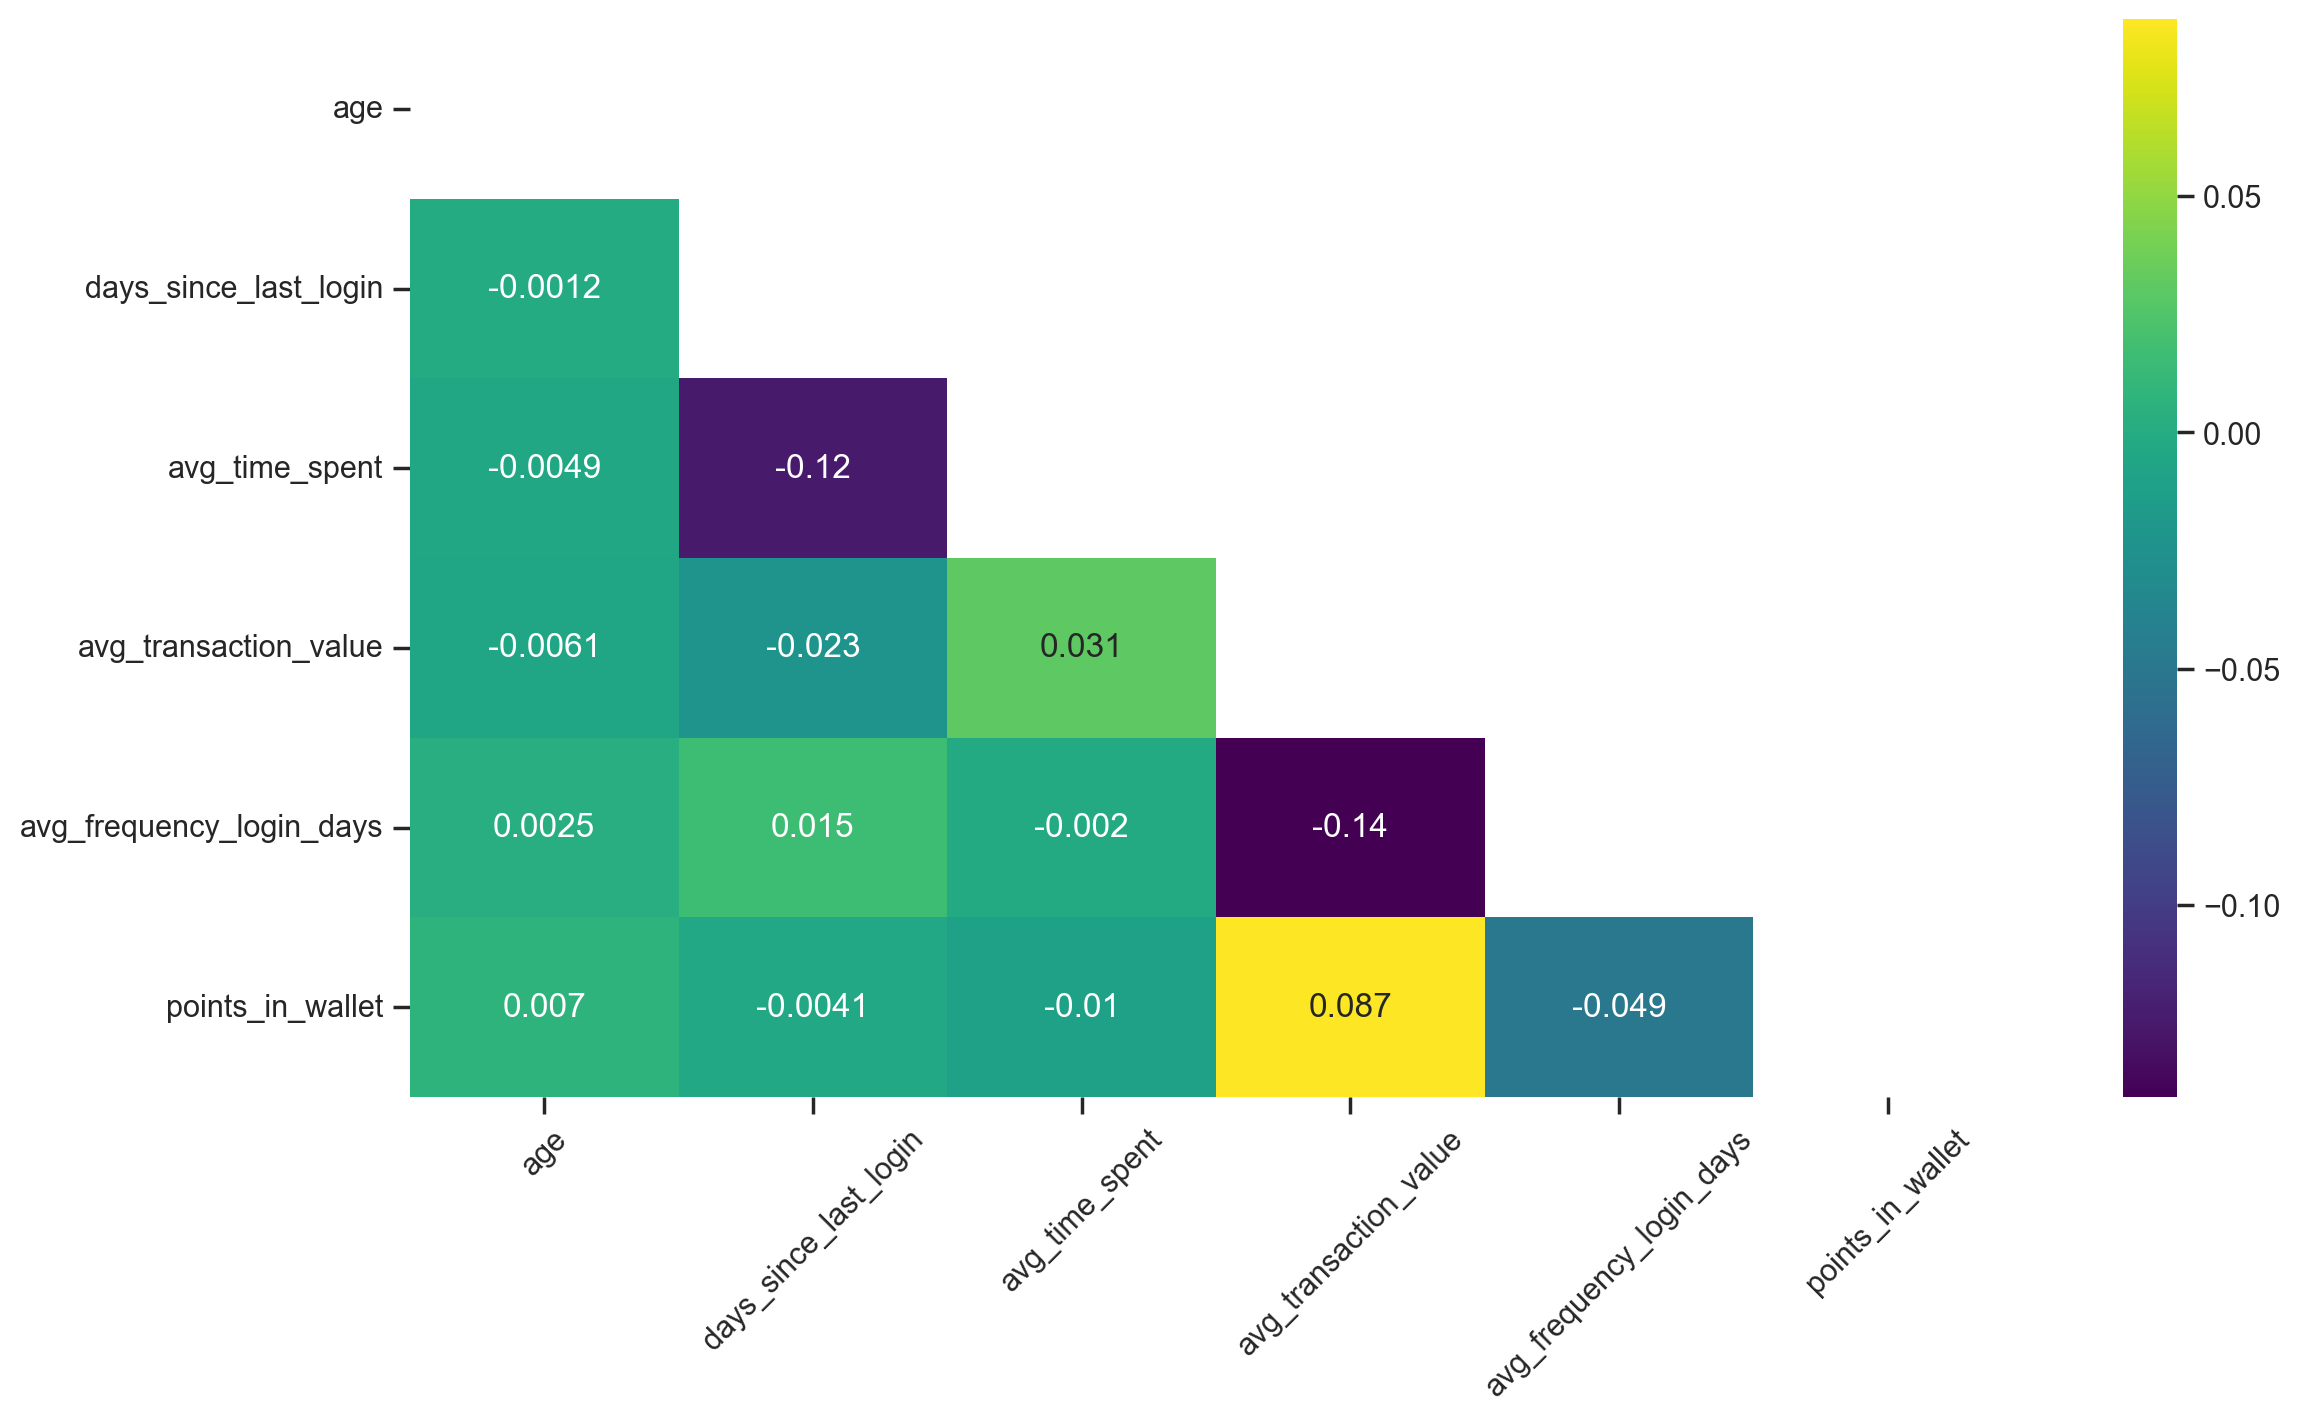

In [100]:
# Plotting the correlation between the numerical features
def plot_correlation(df: pd.DataFrame) -> None:
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(13, 7))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(df.corr(), annot=True, ax=ax, cmap='viridis', mask=mask)

    plt.xticks(rotation=45)

    plt.show()


plot_correlation(num)

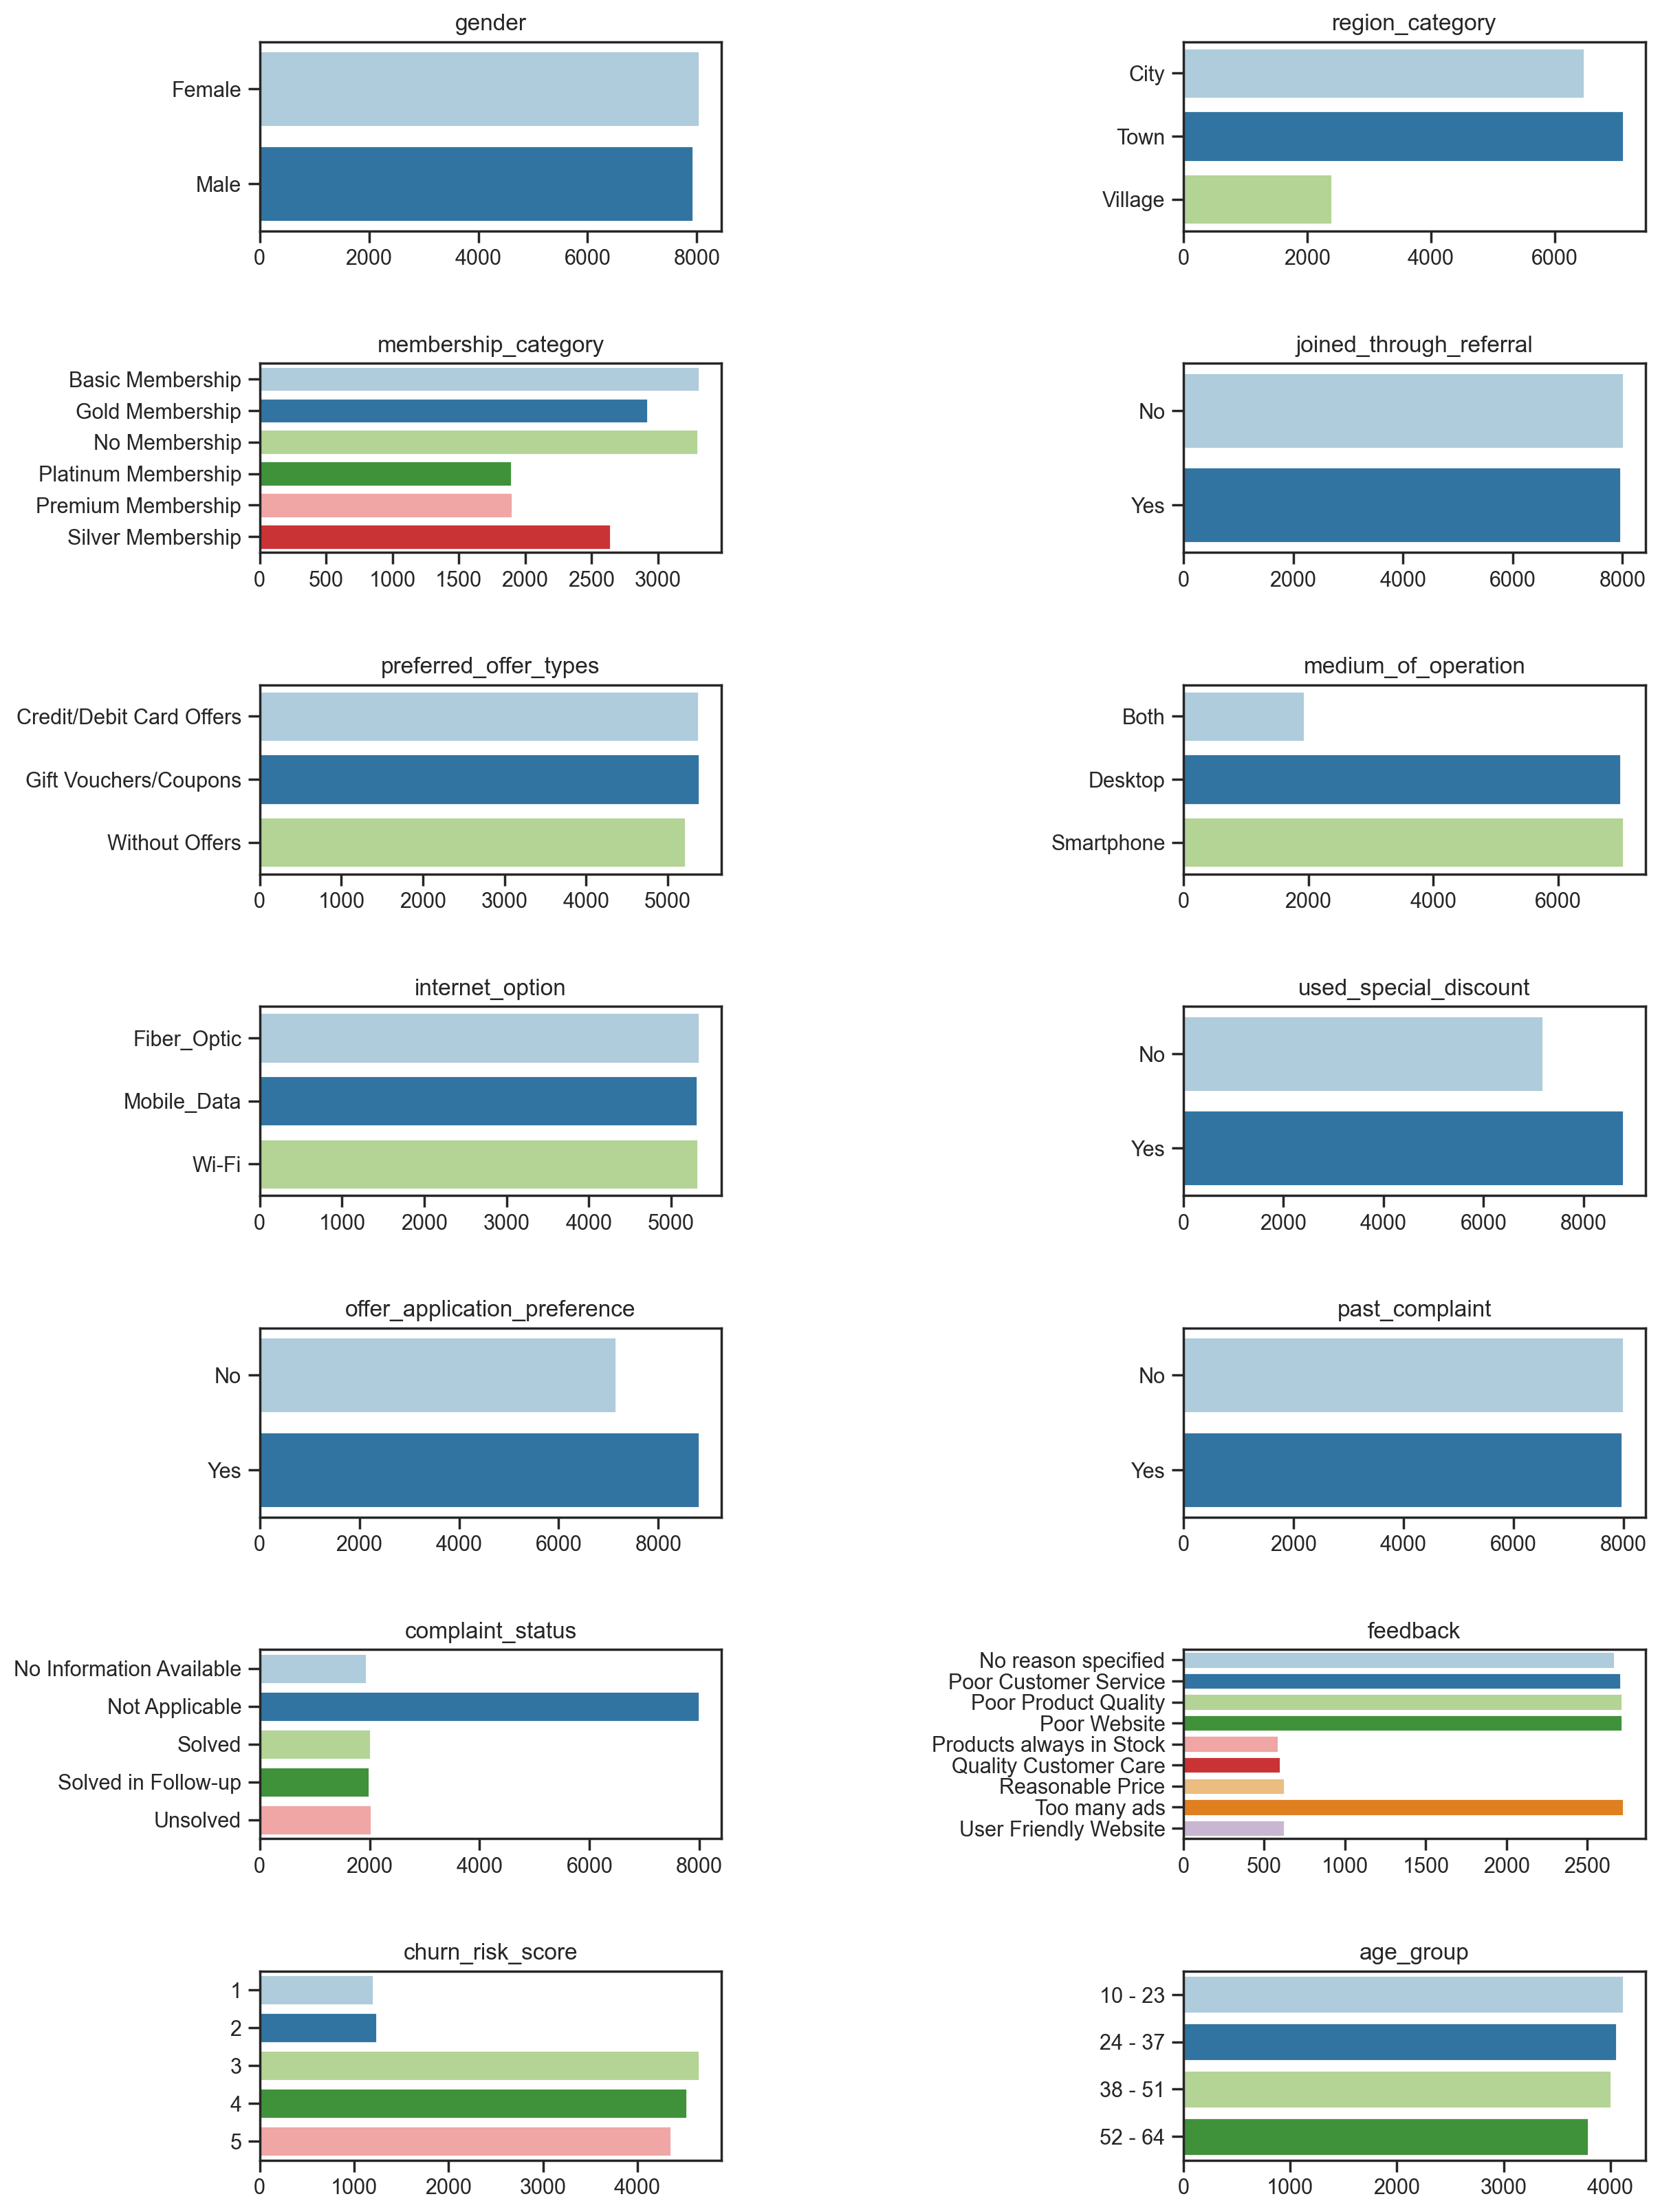

In [101]:
# Plotting the distribution of categorical features
def plot_category(df: pd.DataFrame) -> None:
    sns.set_palette('Paired')
    fig, axes = plt.subplots(7, 2, figsize=(13, 20))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.countplot(data=df, y=col, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.set_ylabel('')
        ax.set_xlabel('')

    fig.subplots_adjust(hspace=0.7, wspace=1)
    plt.show()


plot_category(cat.copy())

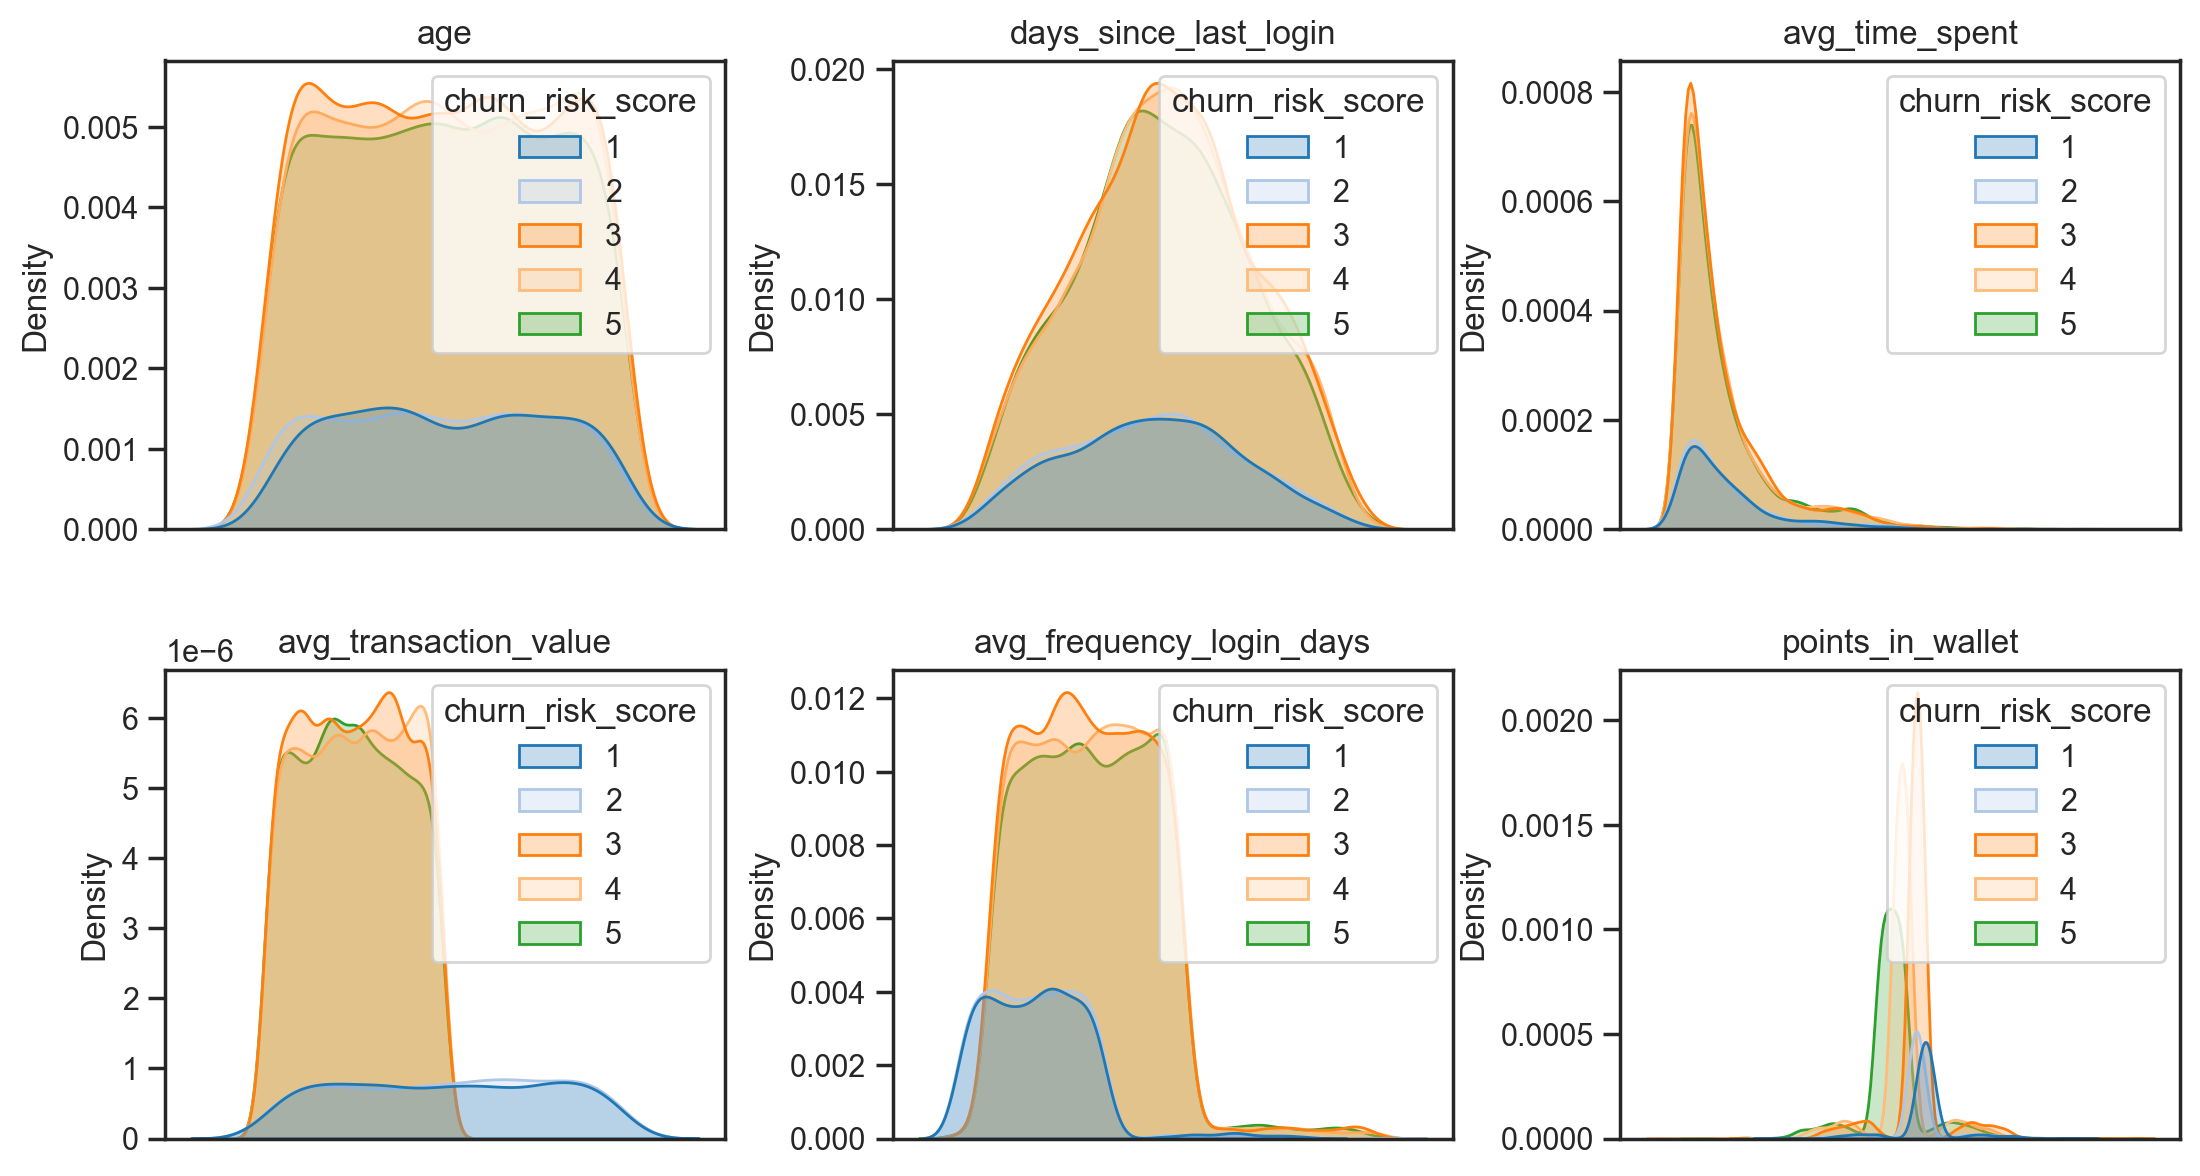

In [102]:
# Plot the distribution of the numerical features by churn risk score
def plot_distribution_by_heart_disease(df: pd.DataFrame) -> None:
    sns.set_palette('tab20')
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))

    for ax, col in zip(axes.flatten(), df.columns.delete(-1)):
        sns.kdeplot(data=df, x=col, hue='churn_risk_score', ax=ax, fill=True)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_distribution_by_heart_disease(pd.concat([num, cat['churn_risk_score']], axis=1))

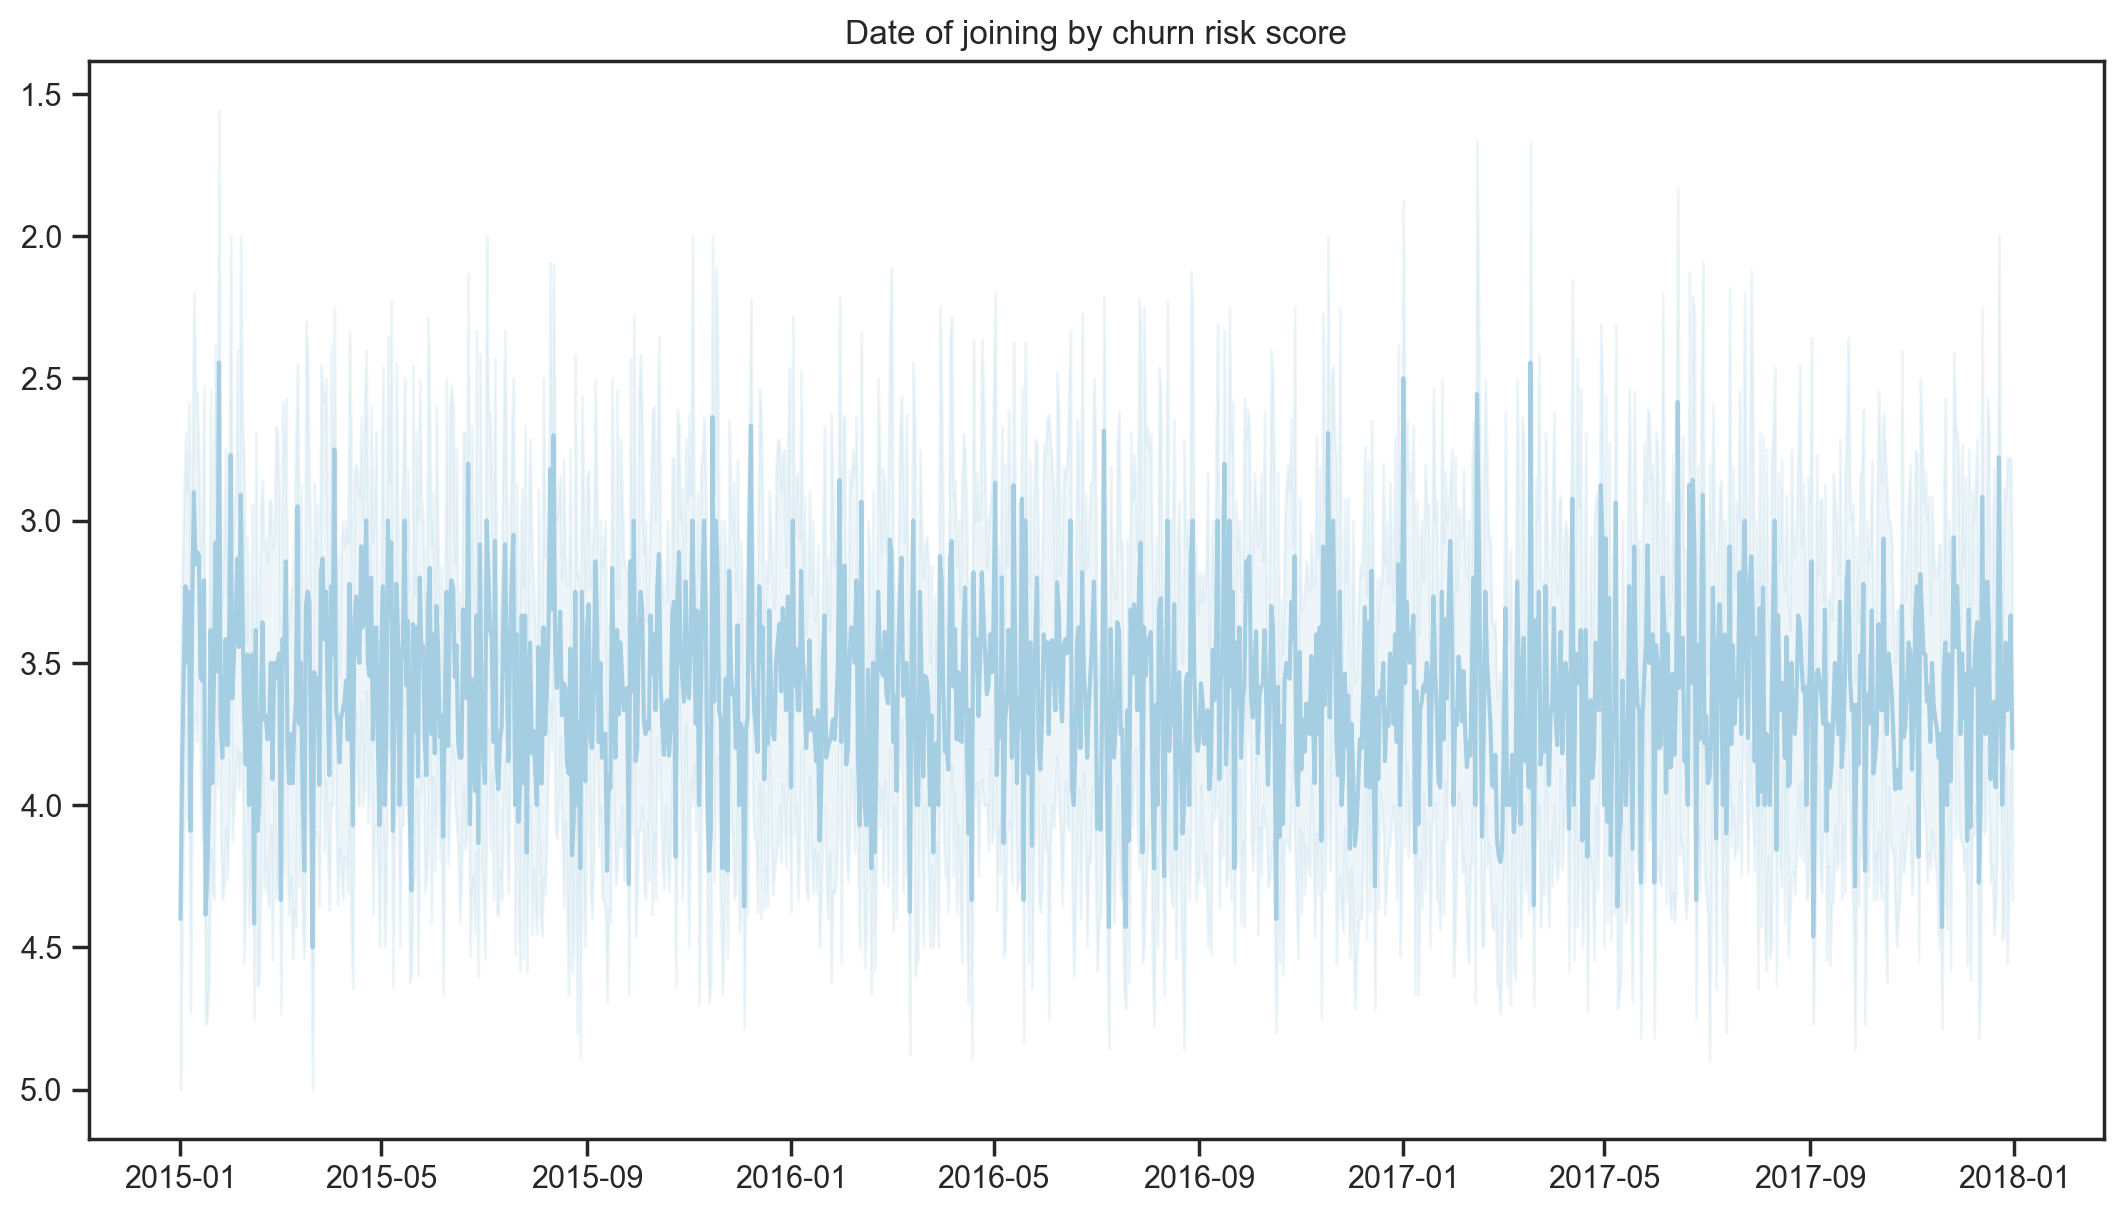

In [103]:
# Plot date of joining by churn risk score
def plot_date_of_joining_by_churn_risk_score(df: pd.DataFrame) -> None:
    sns.set_palette('Paired')
    fig, ax = plt.subplots(figsize=(13, 7))

    sns.lineplot(data=df, x='joining_date', y='churn_risk_score', ax=ax)
    ax.set_title('Date of joining by churn risk score', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

    plt.show()


plot_date_of_joining_by_churn_risk_score(pd.concat([dt, cat['churn_risk_score']], axis=1))

### What is the most common churn risk score by age group?

In [104]:
# Ranking churn risk score by age group
def rank_churn_risk_score_by_age_group(df: pd.DataFrame) -> style.Styler:
    age_group = (
        df
        .groupby(['age_group', 'churn_risk_score'])
        .size()
        .reset_index(name='counts')
    )

    pivot_table = (
        pd
        .pivot_table(age_group,
                     values='counts',
                     index='churn_risk_score',
                     columns='age_group')
        .rank(ascending=False, axis=0)
    )

    return (
        format_table(pivot_table)
        .format('{:.0f}')
        .background_gradient(cmap='summer')
        .set_caption(
            'Table 3. Ranking churn risk score by age group'
        )
    )


rank_churn_risk_score_by_age_group(eda)

age_group,10 - 23,24 - 37,38 - 51,52 - 64
churn_risk_score,,,,
1,5,4,5,4
2,4,5,4,5
3,1,1,1,1
4,2,2,2,2
5,3,3,3,3


According to Table 3, the blue color indicates the most frequency churn risk score by age group. Based on the data, we can conclude the following:
- *****3*** is the most common churn risk score for all age groups.**
- *****4*** is the second most common churn risk score for all age groups.**
- *****5*** is the third most common churn risk score for all age groups.**
- *****2*** is the fourth most common churn risk score across all age groups except for the 24-36 and 52-64 age groups.**, where it is the fifth most common churn risk score.
- *****1*** is the fifth most common churn risk score across all age groups except for the 24-36 and 52-64 age groups.**, where it is the fourth most common churn risk score.

We can also visualize the count of churn risk score highlighting in green what has been recognized as the most frequency of the churn risk score.

Figure 1. Count of churn risk score by age group


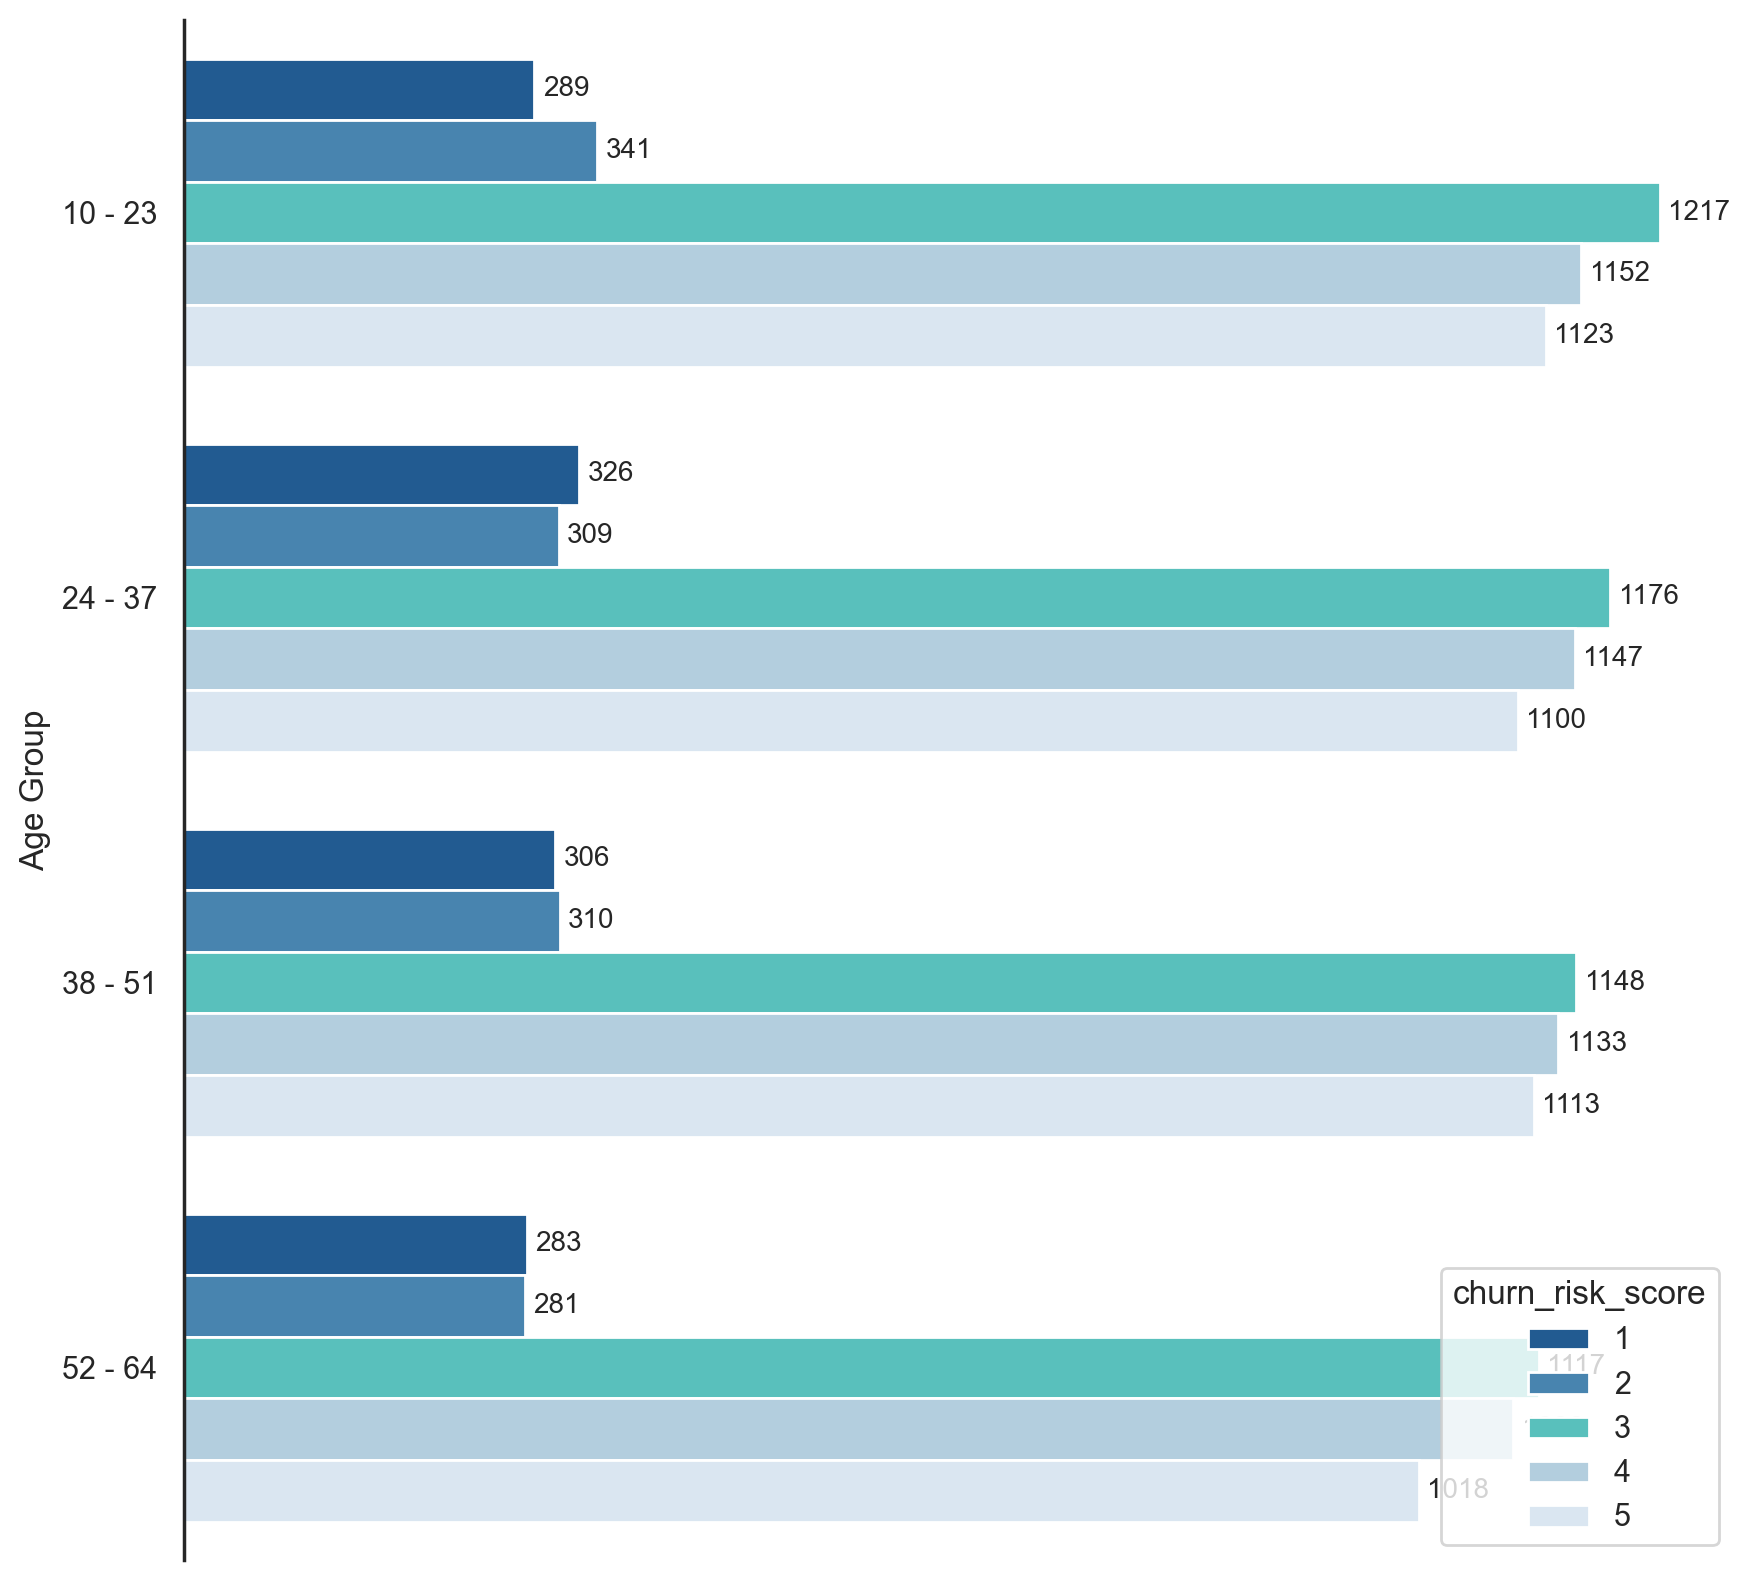

In [105]:
# Plotting the count of churn risk score by age group
def plot_count_of_churn_risk_score_by_age_group(df: pd.DataFrame) -> None:
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 10))

    unique_score = sorted(tuple(df['churn_risk_score'].unique().astype(int)))
    blues = sns.color_palette('Blues', n_colors=len(unique_score))
    custom_palette = ['mediumturquoise' if score == 3
                      else blues[len(unique_score) - 1 - i]
                      for i, score in enumerate(unique_score)]
    sns.countplot(data=df,
                  y='age_group',
                  hue='churn_risk_score',
                  order=df.age_group.sort_values().unique(),
                  palette=custom_palette)

    for bar in ax.patches:
        width = bar.get_width()
        x_ = width
        y_ = bar.get_y() + bar.get_height() / 2
        label = f"{width:.0f}"
        ax.annotate(label, (x_, y_),
                    ha='left', va='center',
                    xytext=(3, 0), fontsize=10,
                    textcoords='offset points')

    sns.despine(bottom=True)
    plt.ylabel('Age Group', fontsize=12)
    plt.xlabel('')
    plt.xticks([])

    plt.show()


print('Figure 1. Count of churn risk score by age group')
plot_count_of_churn_risk_score_by_age_group(eda)

### Explore the relationship between churn risk score and other features

#### Is churn risk score and region category independent?
- **Null hypothesis:** churn risk score and region category are independent.
- **Alternative hypothesis:** churn risk score and region category are dependent.
- **Threshold:** p-value < 0.05

In [106]:
# Chi-square test for region and churn risk score
def chi_square_test_for_region_and_churn_risk_score(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['region_category'], df['churn_risk_score']))

    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')


chi_square_test_for_region_and_churn_risk_score(eda)

Chi-square test of independence: 57.51049027672282
p-value: 1.431518582495493e-09
Degrees of freedom: 8
Expected frequencies: [[ 488.07757272  503.07663434 1888.26024398 1835.56083829 1765.02471067]
 [ 535.37891774  551.83159212 2071.25830466 2013.45161089 1936.0795746 ]
 [ 180.54350954  186.09177354  698.48145136  678.98755083  652.89571473]]
p-value < 0.05: True


The p-value is less than 0.05, which means that we can reject the null hypothesis that churn risk score and region category are independent. Therefore, we can conclude that churn risk score and region category are dependent.

#### Is churn risk score and membership category independent?
- **Null hypothesis:** churn risk score and membership category are independent.
- **Alternative hypothesis:** churn risk score and membership category are dependent.
- **Threshold:** p-value < 0.05

In [107]:
# Chi-square test for membership and churn risk score
def chi_square_test_for_membership_and_churn_risk_score(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['membership_category'], df['churn_risk_score']))

    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')


chi_square_test_for_membership_and_churn_risk_score(eda)

Chi-square test of independence: 14071.686913356194
p-value: 0.0
Degrees of freedom: 20
Expected frequencies: [[249.68783234 257.3609634  965.98498592 939.02533625 902.94088208]
 [220.23747263 227.00556772 852.04829528 828.26850172 796.44016265]
 [248.70866437 256.35170472 962.19680951 935.34288395 899.39993744]
 [142.883203   147.274132   552.78235846 537.3547701  516.70553644]
 [143.41044729 147.81757898 554.82214576 539.33762903 518.61219894]
 [199.07238036 205.19005317 770.16540507 748.67087895 719.90128245]]
p-value < 0.05: True


The p-value is less than 0.05, which means that we can reject the null hypothesis that churn risk score and membership category are independent. Therefore, we can conclude that churn risk score and membership category are dependent.

#### Is churn risk score and complaint status independent?
- **Null hypothesis:** churn risk score and complaint status are independent.
- **Alternative hypothesis:** churn risk score and complaint status are dependent.
- **Threshold:** p-value < 0.05

In [108]:
# Chi-square test for complaint status and churn risk score
def chi_square_test_for_complaint_status_and_churn_risk_score(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['complaint_status'], df['churn_risk_score']))

    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')


chi_square_test_for_complaint_status_and_churn_risk_score(eda)

Chi-square test of independence: 24.62955889148558
p-value: 0.07662767871404312
Degrees of freedom: 16
Expected frequencies: [[ 146.27263059  150.76771974  565.89527682  550.10172036  528.96265249]
 [ 602.64022521  621.15989991 2331.47688458 2266.40775727 2179.31523303]
 [ 152.29827964  156.97854238  589.20713169  572.76296528  550.75308101]
 [ 150.26462308  154.88238974  581.33938067  565.11479512  543.39881139]
 [ 152.52424148  157.21144823  590.08132624  573.61276196  551.57022208]]
p-value < 0.05: False


The p-value is greater than 0.05, which means that we cannot reject the null hypothesis that churn risk score and complaint status are independent.

#### Is churn risk score and feedback independent?
- **Null hypothesis:** churn risk score and feedback are independent.
- **Alternative hypothesis:** churn risk score and feedback are dependent.
- **Threshold:** p-value < 0.05

In [109]:
# Chi-square test for feedback and churn risk score
def chi_square_test_for_feedback_and_churn_risk_score(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['feedback'], df['churn_risk_score']))

    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')


chi_square_test_for_feedback_and_churn_risk_score(eda)

Chi-square test of independence: 16043.725739280115
p-value: 0.0
Degrees of freedom: 32
Expected frequencies: [[201.25667814 207.44147638 778.61595246 756.88558023 727.80031279]
 [204.11886143 210.39161714 789.68908352 767.64967157 738.15076634]
 [204.4954645  210.77979356 791.14607444 769.06599937 739.51266813]
 [204.79674695 211.09033469 792.31166719 770.19906162 740.60218955]
 [ 44.3638411   45.72718173 171.63353144 166.8434157  160.43203003]
 [ 45.34300907  46.73644041 175.42170785 170.525868   163.97297466]
 [ 47.30134501  48.75495777 182.99806068 177.8907726  171.05486393]
 [205.17335002 211.4785111  793.76865812 771.61538943 741.96409134]
 [ 47.15070378  48.59968721 182.41526431 177.32424148 170.51010322]]
p-value < 0.05: True


The p-value is less than 0.05, which means that we can reject the null hypothesis that churn risk score and feedback are independent. Therefore, we can conclude that churn risk score and feedback are dependent.

## Model Building

### Feature Engineering

In [110]:
ml = data.copy()
ml['last_visit'] = pd.to_datetime(ml['joining_date']) + \
                   pd.to_timedelta(ml['days_since_last_login'], unit='D')
ml['last_visit'] = ml['last_visit'].astype(str)
ml['last_visit'] = ml['last_visit'] + ' ' + ml['last_visit_time'].astype(str)
ml['last_visit'] = pd.to_datetime(ml['last_visit'])

ml['last_visit_year'] = ml['last_visit'].dt.year
ml['last_visit_month'] = ml['last_visit'].dt.month
ml['last_visit_day'] = ml['last_visit'].dt.day
ml['last_visit_hour'] = ml['last_visit'].dt.hour
ml['last_visit_minute'] = ml['last_visit'].dt.minute
ml['last_visit_second'] = ml['last_visit'].dt.second

ml.drop(['joining_date', 'last_visit', 'last_visit_time'], axis=1, inplace=True)

seed = 1

In [111]:
# Split data
def split_data(
        df: pd.DataFrame,
        test_size: float,
        random_state: int) -> list[pd.DataFrame, pd.Series]:
    x_ = df.drop('churn_risk_score', axis=1)
    y_ = df['churn_risk_score']

    x_train_, x_test_, y_train_, y_test_ = train_test_split(
        x_, y_,
        test_size=test_size,
        random_state=random_state
    )

    return [x_, y_, x_train_, x_test_, y_train_, y_test_]

In [112]:
# Create pipelines
def create_pipelines(features: pd.DataFrame) -> dict[str, Pipeline]:
    num_selector = make_column_selector(dtype_include='number')
    cat_selector = make_column_selector(dtype_include='category')

    num_cols = num_selector(features)
    cat_cols = cat_selector(features)

    num_preprocessor = StandardScaler()
    cat_preprocessor = OneHotEncoder()

    preprocessor = ColumnTransformer([
        ('StandardScaler', num_preprocessor, num_cols),
        ('OneHotEncoder', cat_preprocessor, cat_cols)
    ])

    return {
        'Logistic Regression': make_pipeline(preprocessor,
                                             LogisticRegression(n_jobs=-1, max_iter=1000, random_state=seed)),
        'KNN': make_pipeline(preprocessor, KNeighborsClassifier(n_jobs=-1)),
        'Decision Tree': make_pipeline(preprocessor, DecisionTreeClassifier(random_state=seed)),
        'Random Forest': make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, random_state=seed)),
        'SVC': make_pipeline(preprocessor, SVC()),
    }

In [113]:
x, y, x_train, x_test, y_train, y_test = split_data(ml.copy(), 0.2, seed)
pipelines = create_pipelines(x)

### Model Training

In [114]:
# Get the model metrics
def get_model_metrics(model: Pipeline,
                      x_train_: pd.DataFrame,
                      y_train_: pd.Series,
                      x_test_: pd.DataFrame,
                      y_test_: pd.Series) -> list[float]:
    model.fit(x_train_, y_train_)

    y_train_pred = model.predict(x_train_)
    y_test_pred = model.predict(x_test_)

    train_accuracy = accuracy_score(y_train_, y_train_pred)
    test_accuracy = accuracy_score(y_test_, y_test_pred)

    train_f1 = f1_score(y_train_, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test_, y_test_pred, average='weighted')

    train_precision = precision_score(y_train_, y_train_pred, average='weighted')
    test_precision = precision_score(y_test_, y_test_pred, average='weighted')

    return [train_accuracy, test_accuracy, train_f1, test_f1, train_precision, test_precision]


# Get the model metrics for all models
def get_model_metrics_for_all_models(pipelines_: dict[str, Pipeline],
                                     x_train_: pd.DataFrame,
                                     y_train_: pd.Series,
                                     x_test_: pd.DataFrame,
                                     y_test_: pd.Series) -> pd.DataFrame:
    model_metrics = pd.DataFrame(index=[
        'Train Accuracy', 'Test Accuracy', 'Train F1', 'Test F1', 'Train Precision', 'Test Precision'])

    for model_name, model in pipelines_.items():
        model_metrics.loc[:, model_name] = get_model_metrics(model, x_train_, y_train_, x_test_, y_test_)

    return model_metrics


(
    format_table(
        get_model_metrics_for_all_models(pipelines,
                                         x_train,
                                         y_train,
                                         x_test,
                                         y_test)
    )
    .format('{:.2f}')
    .background_gradient(cmap='summer')
    .set_table_attributes(
        'style="font-size: 16px; margin: 0 auto;"'
    )
)

,Logistic Regression,KNN,Decision Tree,Random Forest,SVC
Train Accuracy,0.73,0.68,1.00,1.00,0.80
Test Accuracy,0.73,0.46,0.78,0.78,0.70
Train F1,0.71,0.67,1.00,1.00,0.78
Test F1,0.70,0.46,0.78,0.78,0.67
Train Precision,0.74,0.68,1.00,1.00,0.82
Test Precision,0.73,0.47,0.78,0.78,0.69


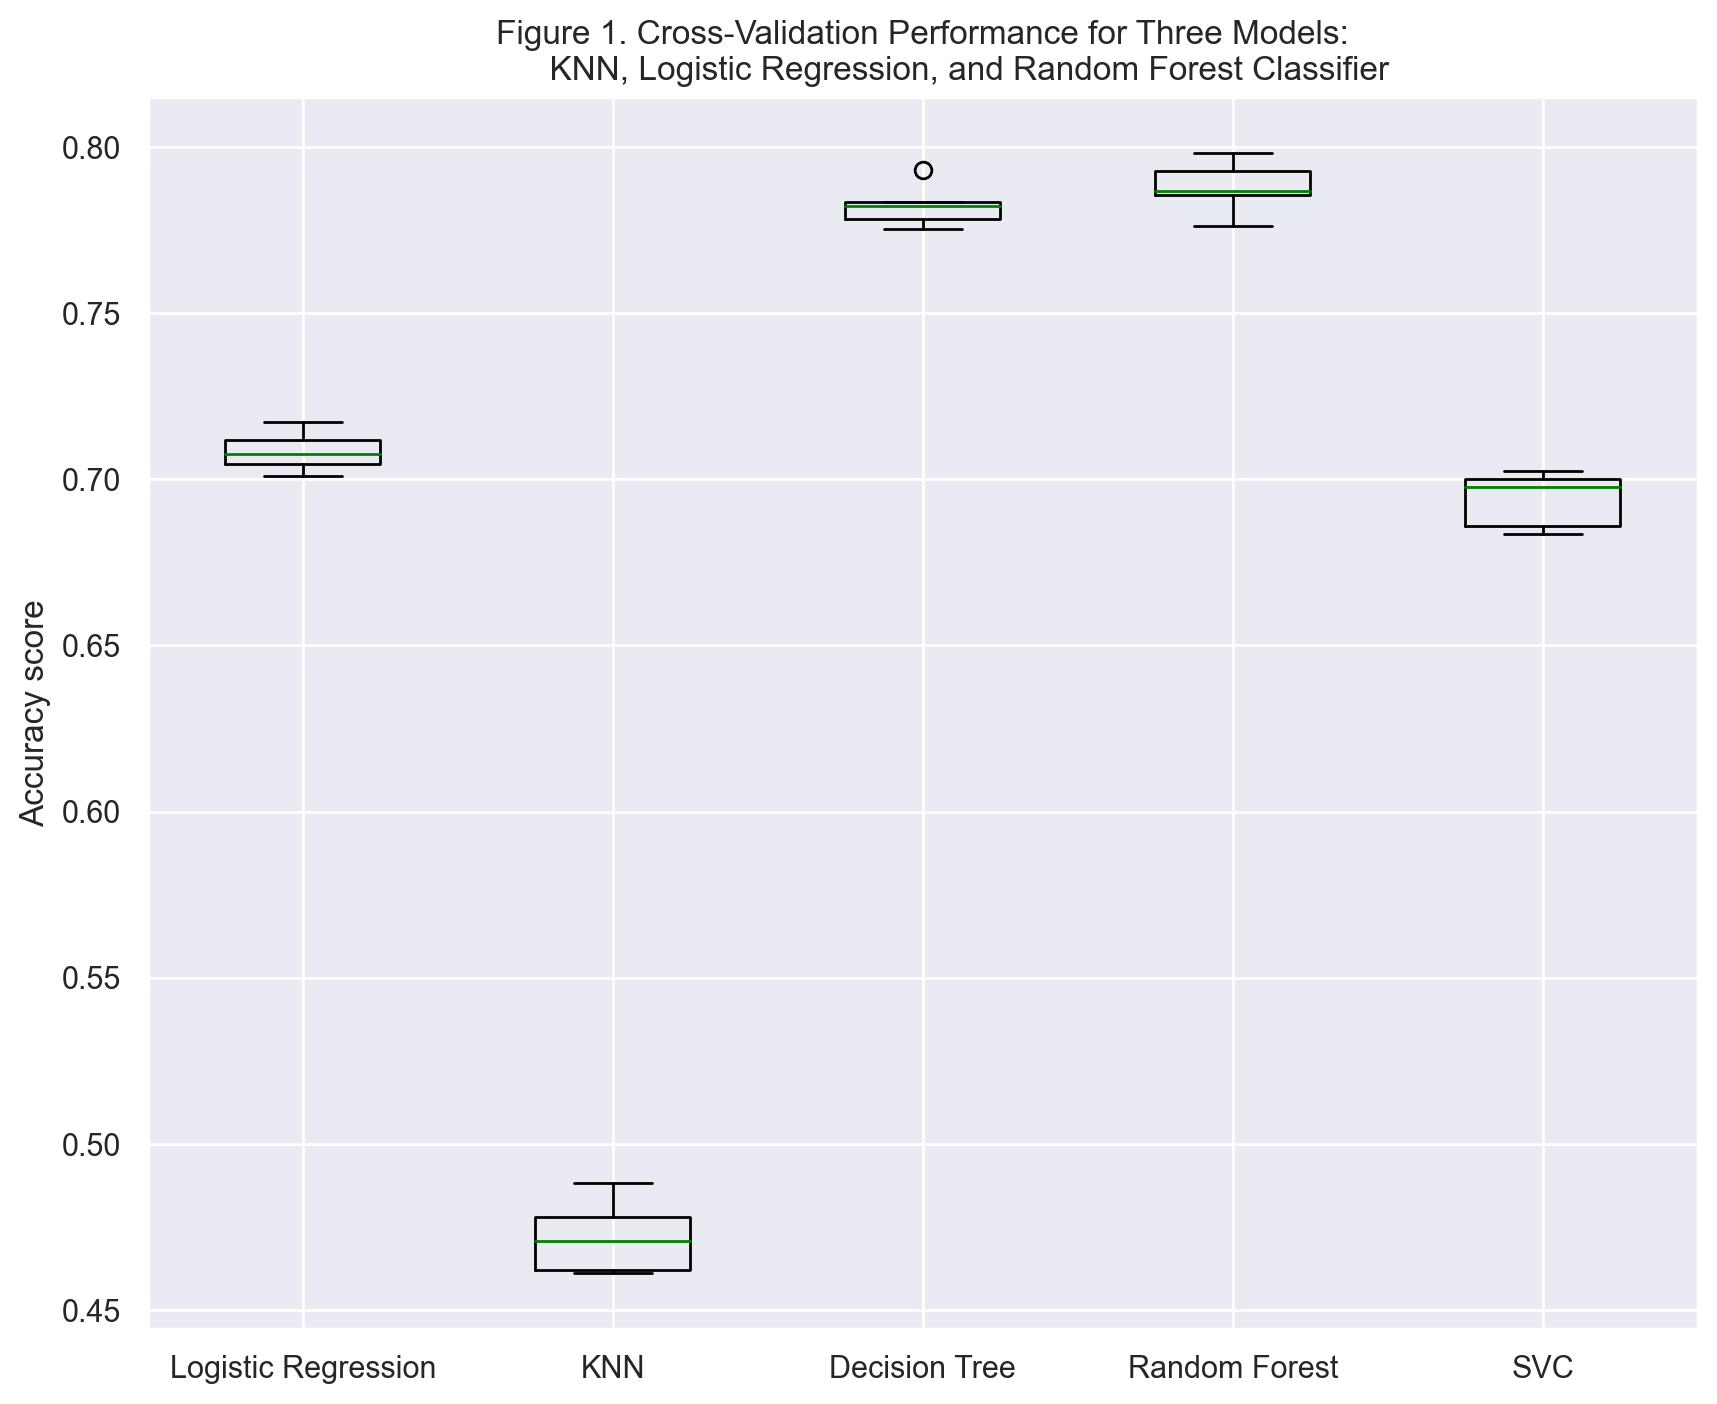

,Test Set Accuracy
Logistic Regression,0.72568
KNN,0.46356
Decision Tree,0.77604
Random Forest,0.783234
SVC,0.697529


In [115]:
# Evaluating multiple models
def boxplot_cv_performances_from_pipes(x_train_: pd.DataFrame,
                                       y_train_: pd.Series,
                                       x_test_: pd.DataFrame,
                                       y_test_: pd.Series) -> pd.DataFrame:
    results = []

    for pipeline in pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train_, y_train_, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=list(pipelines.keys()),
                medianprops={'color': 'green'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.title('Figure 1. Cross-Validation Performance for Three Models:\n\
          KNN, Logistic Regression, and Random Forest Classifier')
    plt.show()

    # Test set performance
    test_set_performance = pd.DataFrame(index=list(pipelines.keys()),
                                        columns=['Test Set Accuracy'])
    for name, pipeline in pipelines.items():
        pipeline.fit(x_train_, y_train_)
        y_pred = pipeline.predict(x_test_)
        test_set_performance.loc[name, 'Test Set Accuracy'] = accuracy_score(y_test_, y_pred)

    return test_set_performance


boxplot_cv_performances_from_pipes(x_train, y_train, x_test, y_test)

In [116]:
from sklearn.model_selection import GridSearchCV


# Hyperparameter tuning
def hyperparameter_tuning(model: Pipeline,
                          param_grid: dict[str, list],
                          x_train_: pd.DataFrame,
                          y_train_: pd.Series,
                          x_test_: pd.DataFrame,
                          y_test_: pd.Series) -> tuple[GridSearchCV, pd.DataFrame]:
    grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid.fit(x_train_, y_train_)

    y_train_pred = grid.predict(x_train_)
    y_test_pred = grid.predict(x_test_)

    train_accuracy = accuracy_score(y_train_, y_train_pred)
    test_accuracy = accuracy_score(y_test_, y_test_pred)

    train_f1 = f1_score(y_train_, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test_, y_test_pred, average='weighted')

    train_precision = precision_score(y_train_, y_train_pred, average='weighted')
    test_precision = precision_score(y_test_, y_test_pred, average='weighted')

    return grid, pd.DataFrame(
        data=[[train_accuracy, test_accuracy, train_f1, test_f1, train_precision, test_precision]],
        columns=['Train Accuracy', 'Test Accuracy', 'Train F1', 'Test F1', 'Train Precision', 'Test Precision']
    )

In [117]:
# Hyperparameter tuning for Logistic Regression
logistic_regression_param_grid = {
    'logisticregression__penalty': ['l2', None],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
}

logistic_regression_grid, logistic_regression_metrics = hyperparameter_tuning(
    pipelines['Logistic Regression'],
    logistic_regression_param_grid,
    x_train,
    y_train,
    x_test,
    y_test
)

print(f"Logistic Regression Best Parameters: {logistic_regression_grid.best_params_}")
print(f"Logistic Regression Best Score: {logistic_regression_grid.best_score_}")
logistic_regression_metrics

/Users/phuchuynh/DataspellProjects/Final/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/phuchuynh/DataspellProjects/Final/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/phuchuynh/DataspellProjects/Final/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/phuchuynh/DataspellProjects/Final/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Best Parameters: {'logisticregression__penalty': None, 'logisticregression__solver': 'newton-cg'}
Logistic Regression Best Score: 0.7091799695633842


,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision
0,0.732014,0.72568,0.712614,0.703547,0.740177,0.731961


In [118]:
# Hyperparameter tuning for KNN
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 50, 2),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

knn_grid, knn_metrics = hyperparameter_tuning(
    pipelines['KNN'],
    knn_param_grid,
    x_train,
    y_train,
    x_test,
    y_test
)

print(f"KNN Best Parameters: {knn_grid.best_params_}")
print(f"KNN Best Score: {knn_grid.best_score_}")
knn_metrics

KNN Best Parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 43, 'kneighborsclassifier__weights': 'distance'}
KNN Best Score: 0.6195645307321451


,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision
0,1.0,0.617141,1.0,0.590204,1.0,0.6109


In [119]:
# Hyperparameter tuning for SVC
svc_param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__break_ties': [True, False]
}

svc_grid, svc_metrics = hyperparameter_tuning(
    pipelines['SVC'],
    svc_param_grid,
    x_train,
    y_train,
    x_test,
    y_test
)

print(f"SVC Best Parameters: {svc_grid.best_params_}")
print(f"SVC Best Score: {svc_grid.best_score_}")
svc_metrics

SVC Best Parameters: {'svc__break_ties': True, 'svc__kernel': 'linear'}
SVC Best Score: 0.7032399370964373


,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision
0,0.73569,0.725993,0.708444,0.695907,0.756268,0.743116


In [120]:
# Hyperparameter tuning for Decision Tree
decision_tree_param_grid = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': np.arange(1, 50, 2),
    'decisiontreeclassifier__min_samples_split': np.arange(2, 10, 2),
    'decisiontreeclassifier__min_samples_leaf': np.arange(1, 10, 2)
}

decision_tree_grid, decision_tree_metrics = hyperparameter_tuning(
    pipelines['Decision Tree'],
    decision_tree_param_grid,
    x_train,
    y_train,
    x_test,
    y_test
)

print(f"Decision Tree Best Parameters: {decision_tree_grid.best_params_}")
print(f"Decision Tree Best Score: {decision_tree_grid.best_score_}")
decision_tree_metrics

Decision Tree Best Parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 13, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 4}
Decision Tree Best Score: 0.7872994245663302


,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision
0,0.861198,0.788239,0.858058,0.783139,0.860361,0.784147


In [121]:
# Hyperparameter tuning for Random Forest
random_forest_param_grid = {
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}

random_forest_grid, random_forest_metrics = hyperparameter_tuning(
    pipelines['Random Forest'],
    random_forest_param_grid,
    x_train,
    y_train,
    x_test,
    y_test
)

print(f"Random Forest Best Parameters: {random_forest_grid.best_params_}")
print(f"Random Forest Best Score: {random_forest_grid.best_score_}")
random_forest_metrics

Random Forest Best Parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt'}
Random Forest Best Score: 0.791835012382266


,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision
0,1.0,0.78386,1.0,0.775808,1.0,0.783849


We choose the Decision Tree model and SVC model because they have the high score in the test set, and these models are not overfitting.

In [122]:
# Export models
pickle.dump(decision_tree_grid, open('decision_tree_model.pkl', 'wb'))
pickle.dump(svc_grid, open('svc_model.pkl', 'wb'))